# COVID-19 Simulation

COVID-19 is affecting all of us and while most have no accepted we need some kind of social distancing to stop the spread of the virus, one big question remains: how long is this going to take?

The pandemic has sent the world into turmoil and we are moving in to uncharted waters … effectively, we have never experienced a pandemic of this scale AND economic implications … most likely this is also the first time we have captured so much data about a pandemic almost in realtime.

Whenever you need to make predictions about complex situations you have little prior experienced with, models and simuations are a good starting point to explore the situations, test your assumptions, design strategies to deal with the situation and make qualitiative and quantitative predictions about which effect the strategies might have.

This notebook contains such as simulation of the COVID-19 pandemic … though is deliberately kept simple to ensure that users understand the underlying model and assumptions, it already is useful in allowing you to explore the implication of social distancing strategies. We have provided the complete code for the simulation in the form of Jupyter notebooks and Python code on [GitHub](https://github.com/transentis/sim-covid-19), so you can expand on the simulation if you would like to. We have also published an interactive dashboard based on the simulation on [covid-sim.com](https://covid-sim.com), which you can experiment with directly.

The underlying model is an implementation of the [SIR model](https://en.wikipedia.org/wiki/Compartmental_models_in_epidemiology#The_SIR_model), which was developed in 1927 by Kermack and McKendrick to model the spreading of epidemics.

![Image](images/sir_model.png)

The SIR model is illustrated above using a System Dynamics stock and flow diagram - it is easy to understand, even if you haven't encountered stock and flow diagrams before:

Essentialy the population consists of those that are susceptible to becoming infected, those that are currently infectious and those that have recovered.

Susceptible people can become infected at a rate defined by the infection rate and infectious people recover at a rate defined by the recovery rate and die at a rate defined by the death rate.

People can only become infected through contact with infectious people, hence the infection rate depends on the number of infectious people, the contact rate (i.e. how many people a person meets every day) and on the infectivity, i.e how likely it is that you will become infected if you meet an infectious person.

The recovery rate just depends on time, i.e. you either recover after a certain time.



The model in this notebook is roughly calibrated to the situation in Germany (as of 27.3.2020). It illustrates the effects of social distancing in achieving the objective of keeping the strain on the health care system as small as possible.

__Assumptions:__

* __Contact Rate.__ Defines how many people a person encounters per day in average, we assume this is about 20 person in the base case.
* __Infectivity.__ Defines the probability that a person becomes infected after contact with an infectious person. We assume this is at 2% in the base case.
* __Duration.__ Defines how long an infective person remains contagious. We assume the duration is 20 days in the base case.
* __Population.__ The susceptible population starts at 80 Mio., the infectious population starts at 120 persons.
* __Intensive Care Needed.__ Measures the number of infected people who need intensive care, set to 2% in the base case.
* __Intensive Care Available.__ The number of intensive care units available, set to 30.000 in the base case.

With the above settings, this means we have a contact number of 8 in the base settings. The contact number is the product of contact rate, infectivity and duration.

## System Dynamics Model

Now let's take a look at the model in more detail. The SIR model discussed here implemented in System Dynamics using the [BPTK-Py](http://bptk.transentis-labs.com) framework.

Best practice is to define all the model varibles first and then to define the model equations using these variables.

In [1]:
from BPTK_Py import Model
from BPTK_Py import sd_functions as sd

model = Model(starttime=1.0,stoptime=1500.0,dt=1.0,name='sir')

### Model Variables

Next we define all the model variables. Ee will set their actual values and their equations in the equation section. 

#### Stocks

The model only has four stocks, as explained above:

In [2]:
susceptible = model.stock("susceptible")  # those that have not been infected yet
infectious = model.stock("infectious") # those that are currently carrying an infection
recovered = model.stock("recovered") # those that have recovered from an infection
deceased = model.stock("deceased") # those that have died from the infection

### Flows

Here are the flows discussed above:

In [3]:
infection_rate = model.flow("infection_rate") # the rate at which people are becoming infected
recovery_rate = model.flow("recovery_rate") # the rate at which people are recovering from an infection
death_rate = model.flow("death_rate") # the rate at which people are dying from an infection

### Constants

The key parameters of the SIR model:

In [ ]:
infectivity = model.constant("infectivity") # the infectivity of the corona virus
lethality = model.constant("lethality") # the lethality of the corona virus
normal_contact_rate=model.constant("normal_contact_rate") # the average contact rate between people in "normal" times
duration = model.constant("duration") # the average time it takes to recover from the virus

The following parameters are used to model the strain on the health care system and in particular the intensive care units:

In [5]:
intensive_available = model.constant("intensive_available") # the number of intensive care units available
intensive_percentage = model.constant("intensive_percentage") # the fraction of people needing intensive care

We also define a few variables that we use in the interactive dashboard presented below:

In [6]:
dashboard_on=model.constant("dashboard_on") # should be equal to 1.0 for dashboard scenario and 0.0 otherwise
distancing_on=model.constant("distancing_on") # defines whether social distancing is on within an interactive scenario
distancing_contact_rate=model.constant("distancing_contact_rate") # interactive scenario: the contact rate when practicing social distancing
distancing_begin=model.constant("distancing_begin") # interactive scenario: when to begin social distancing
distancing_duration=model.constant("distancing_duration")# interactive scenario: when social distancing ends and we return to normal behavior

### Converters

The model doesn't need many converters, the only ones that are essential to the model are the total population and the contact rate:

In [7]:
total_population = model.converter("total_population") # the total population, i.e the sum of susceptible, infected and recovered
contact_rate = model.converter("contact_rate") # the rate at which people are being contacted, in all scenarios

To calculate the strain on the health care system we need to work out the number of intensive care units needed:

In [8]:
intensive_needed = model.converter("intensive_needed") # the number of intensive care units needed at any time

Converters needed to calculate the key indicators:

In [9]:
contact_number = model.converter("contact_number") #  measures which fraction of a susceptible population is infected by a contagious person
reproduction_rate = model.converter("reproduction_rate") # measures the rate at which an epidemic reproduces

We also need a few converters to deal with the different contact rates we use in the dashboard scenarios and detailed scenarios:

In [10]:
variable_contact_rate=model.converter("variable_contact_rate") # the variable contact rate used in the detailed scenarios
dashboard_with_distancing_contact_rate=model.converter("dashboard_with_distancing_contact_rate") # the contact rate used in interactive scenarios with distancing on
dashboard_contact_rate=model.converter("dashboard_contact_rate") # the contact rate used in interactive scenarios with distancing off

### Model Equations

The key part of any System Dynamics model are the equations, let's take some time to investigate these:

We start with an inital value of 80 Mio. people for the `susceptible` stock (i.e. roughly the German population) and assume we have 120 infected people.

In [11]:
susceptible.initial_value = 80000000.0
infectious.initial_value = 120.0
recovered.initial_value = 0.0
deceased.initial_value = 0.0

The settings for infectivity, lethality and the contact rate are the key settings that determine how quickly the epidemic spreads within the population.

We had to make some educated guesses here, as the true infectivity and lethality are currenty not known:

Given the growth rate we saw in Germany with a doubling every two days and assuming that each person has 20 contacts per day on average (under normal circumstances, i.e without social distancing), this resulted in the assumption of an invectivity of 0.02

We assume it takes 20 days to recover from the virus and that the lethality is 0.001

In [12]:
infectivity.equation = 0.02
duration.equation = 20.0
lethality.equation = 0.001

In Germany, there are around 30,000 intensive care units and current data shows that ca 0.2% of the infected need intensive care. The intensive care units needed are simply the infectious multiplied by that percentage.

In [13]:
intensive_percentage.equation = 0.002
intensive_available.equation = 30000.0
intensive_needed.equation =infectious*intensive_percentage

The equations for the stock are easy to define:

* The susceptible population has an outflow defined by the infection rate.
* The infectious population increases through the infection rate and is depleted by the recovery rate and death rate.
* The recovered increase by the covery rate. The  model assumes that reinfection does not happen.
* The deceased increase by the death rate.

In [14]:
susceptible.equation = -infection_rate
infectious.equation = infection_rate - recovery_rate - death_rate
recovered.equation = recovery_rate
deceased.equation = death_rate

The total population decreases slowly according to the death rate. Note that the model only includes deaths for those that die of the corona virus. It also does not consider births.

In [15]:
total_population.equation = susceptible+infectious+recovered

Here are the key equations of the SIR model - they define the underlying dynamics: the infection rate, recovery rate and death rate.

Essentially, infection rate equals the number of infectious people multiplied by the contact rate. This defines how many people come into contact with the virus every day through infected people. But we need to take into account that not every one of these people becomes infected, so we multiply this number by the infectivity. We also need to consider that some people who come into contact with infected people may be infected themselves, hence we multiply by the fraction of susceptible people. This leads to the following equation for  the infection rate:

In [16]:
infection_rate.equation = (contact_rate*infectivity*infectious)*(susceptible/total_population)

The recovery rate is equal to the number of infectous people divided by the duration: not all people recover at the same time, the number of infectious people declines expontentially.

In [17]:
recovery_rate.equation = infectious/duration

The death rate is defined as the number of infectious people multiplied by the lethality.

In [18]:
death_rate.equation = infectious*lethality

Here are the equations for two important indicators of any epidemic, the contact number and the repoduction rate: the contact number is an indicator of how many people an infected person could infect before he recovers, i.e. the product of contact rate, infectivity and duration. The reproduction rate is equal to the contact rate multiplied by the fraction of susceptible people.

In [19]:
contact_number.equation=contact_rate*infectivity*duration
reproduction_rate.equation=contact_number*(susceptible/total_population)

The equations above are almost all you need to simulate the SIR model, all that is missing is a value for the contact rate. In the basic SIR model the contact rate is simply a constant value, and we assume that the average contact rate is 20 for the base settings. Let's quickly test this, to see whether the model is working:

In [20]:
contact_rate.equation=20

Now we can evaluate any variable in the model. e.g. the infectous population:

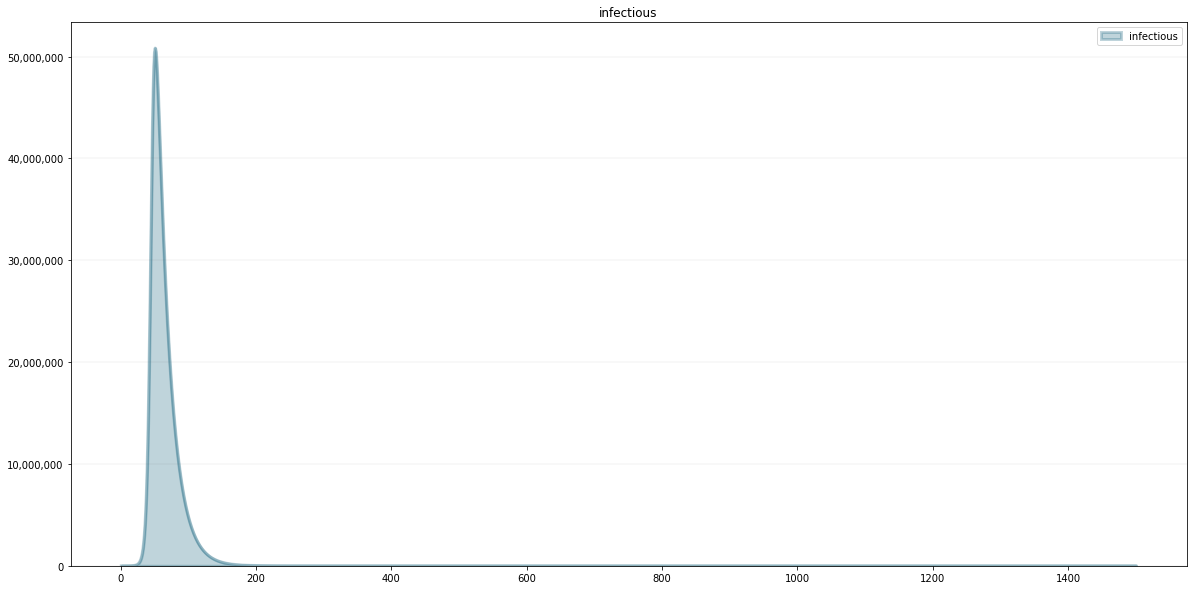

In [21]:
infectious.plot()

But obviously we would like to test some social distancing scenarios, so we need to model the contact rate in a slightly more flexible way.

First of all, we need to be able to differentiate between intractive scenarios within a dashboard, such as the one presented below, and static scenarios that we define for detailed analysis.

Within the dashboard scenario, we want to differentiate between simple scenarios with a constant contact rate (as in the base SIR model) and one where you can set the normal contact rate and the social distancing contact rate, the time when you switch from normal to social distancing and how long you keep up the social distancing.

The static scenarios will allow us to set a different value for the contact rate every day, using a lookup table, so that we can test very differentiated scenarios.

This leads to the following equations for the contact rate:

In [22]:
contact_rate.equation=dashboard_on*dashboard_contact_rate+(-dashboard_on+1.0)*variable_contact_rate
dashboard_on.equation=1.0
distancing_on.equation=0.0
dashboard_contact_rate.equation=distancing_on*dashboard_with_distancing_contact_rate+(-distancing_on+1.0)*normal_contact_rate
dashboard_with_distancing_contact_rate.equation=sd.If(sd.Or(sd.time()<distancing_begin,sd.time()>distancing_begin+distancing_duration),normal_contact_rate,distancing_contact_rate)
normal_contact_rate.equation=20.0
distancing_contact_rate.equation=2.0
distancing_begin.equation=20.0
distancing_duration.equation=200.0

Set the lookup function for the contact rate - for the base setting we will set all points to 20, i.e. we only need to define two points in the lookup table for this:

In [23]:
variable_contact_rate.equation=sd.lookup(sd.time(),"variable_contact_rate")

In [24]:
variable_contact_rate_points = [[0,20.0],[1500,20.0]]

In [25]:
model.points["variable_contact_rate"]=variable_contact_rate_points

## Simulation Dashboard

The simluation dashboard below let's you experiment with different settings for the contact rate and more sophisticated social distancing scenarios. Play with it for a little before you read on about the different scenarios we have analyzed in more detail.

You can also view the dashboard on [covid-sim.com](https://covid-sim.com)

See if you can find a scenario that keeps the number of intensive care units needed below the number of units available.

See what difference it makes if you set the number of contacts to 0 during social distancing or if you keep them at a small number.

If you set the number of contacts to zero, then nobody will become infected and we just move the problem into the future. What needs to be done to avoid this is to keep the infection rate at a level that the health care system can tolerate, but ensuring that the population slowly becomes immune to avoid moving the problem into the future.

This effect also shows a limitation in the SIR model … the recovery rate is modeled as an exponential decay, so the infectious stock never drops completely to zero.

In [26]:
import BPTK_Py
import pandas as pd
bptk = BPTK_Py.bptk()
bptk.register_model(model)

In [27]:
bptk.register_scenarios(
    scenarios ={
        "base": {},
        "weakSocialDistancing": {},
        "strongSocialDistancing": {},
        "shortTermMeasures": {},
        "dashboard":{}
    },
    scenario_manager="smSir")

In [28]:
 bptk.reset_simulation_model(scenario_manager="smSir", scenario="dashboard")

In [29]:
%run src/dashboard/sir_dashboard.ipy

GridBox(children=(IntSlider(value=0, continuous_update=False, description='Visualization Period Begin', layout…

## Scenarios

Now that we have a simulation with the necessary parameters, we can experiment with different scenarios to see what effect social distancing will have and how long it might take before we can get back to a normal situation.

So far we have investigated four scenarios:

* __Base Case.__ In this case we don't change our social behavior and continue as before. The corona virus spreads very quickly, leading to a very high demand on the health care system.
* __Slow social distancing.__ In this case we try to reduce the speed at which the virus spreads, by slowly introducing social distancing. The simulation shows that this hardly has any effect, i.e. the measures taken in Germany to introduce rapid social distancing where right.
* __Rapid social distancing, long-term.__ In this case we introduce rapid social distancing measures and leave them in place for quite some time. The simulation shows that we manage to slow the spread of the virus sufficiently to keep the strain on the health care system low. But unfortunately the measures also take quite some time.
* __Rapid social distancing, short-term.__ In this case we introduce rapid social distancing measures, but ease them very quickly. Unfortunately the simulation shows that this doesn't work - we only manage to move the peak into the future. So unless we manage to come up with other measures such as a vaccine, this strategy will not help.

### Base Case

The base case describes the numbers in Germany and demonstrates what will happen if no measures are taken.

In [30]:
scenario_base= bptk.get_scenario("smSir","base")
scenario_base.constants["interactive_on"]=0.0
bptk.reset_simulation_model(scenario_manager="smSir", scenario="base")

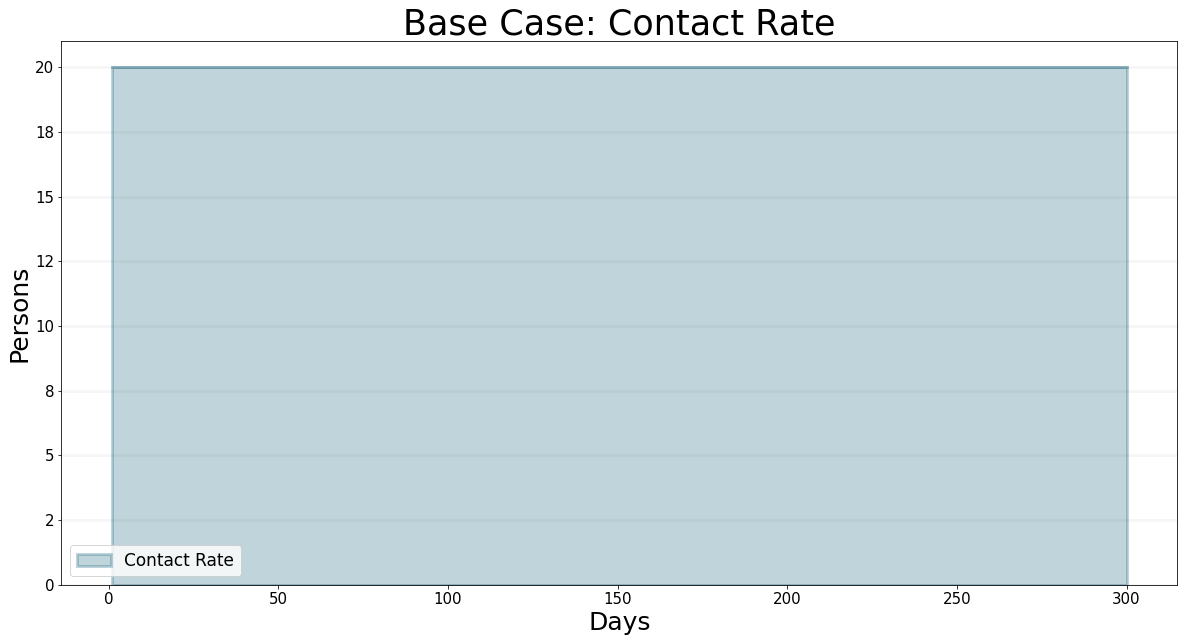

In [31]:
bptk.plot_scenarios(
    scenario_managers=["smSir"],
    scenarios=["base"],
    title="Base Case: Contact Rate",
    x_label="Days",
    y_label="Persons",
    equations=["contact_rate"],
    visualize_to_period=300,
    series_names={
        "smSir_base_contact_rate" : "Contact Rate"
    }
)

Without any measures the numbers lead to explosive exponential growth as shown in the graph above. The graph below zooms in on the first 25 days - the exponential growth is already visible and the numbers match the situation in Germany well.

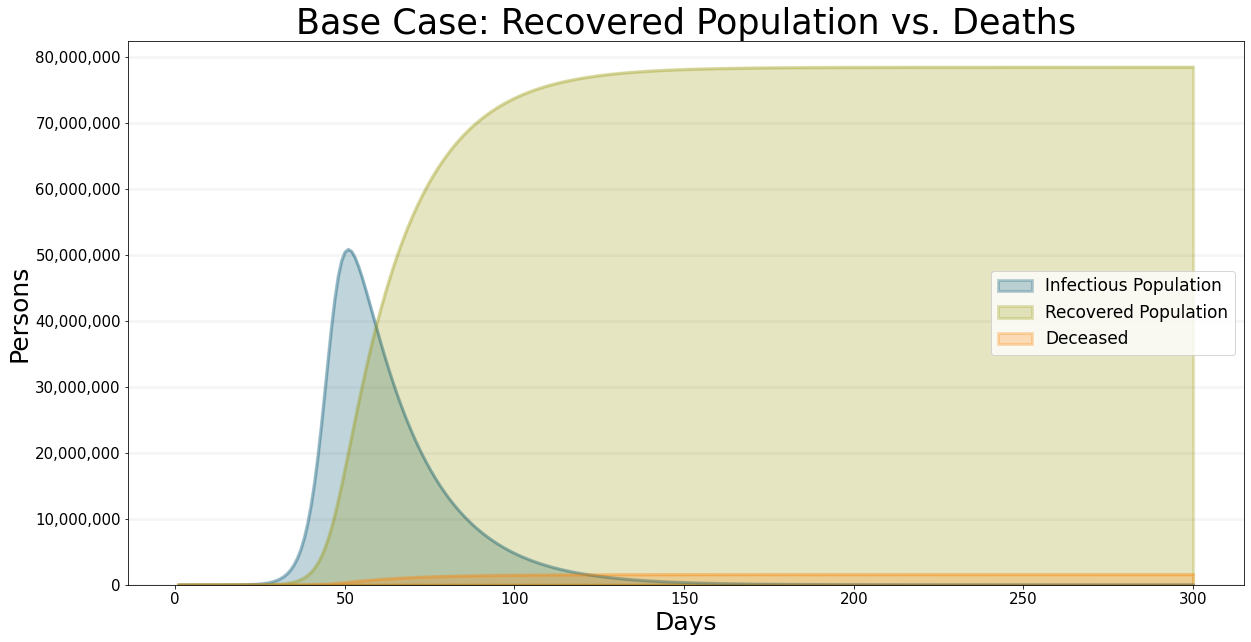

In [32]:
bptk.plot_scenarios(
    scenario_managers=["smSir"],
    scenarios=["base"],
    title="Base Case: Recovered Population vs. Deaths",
    x_label="Days",
    y_label="Persons",
    equations=["infectious","recovered","deceased"],
    visualize_to_period=300,
    series_names={
        "smSir_base_infectious" : "Infectious Population",
        "smSir_base_recovered" : "Recovered Population",
        "smSir_base_deceased": "Deceased"
    }
)

A closer look at the first 25 days shows the model matches the situation in Germany quite well.

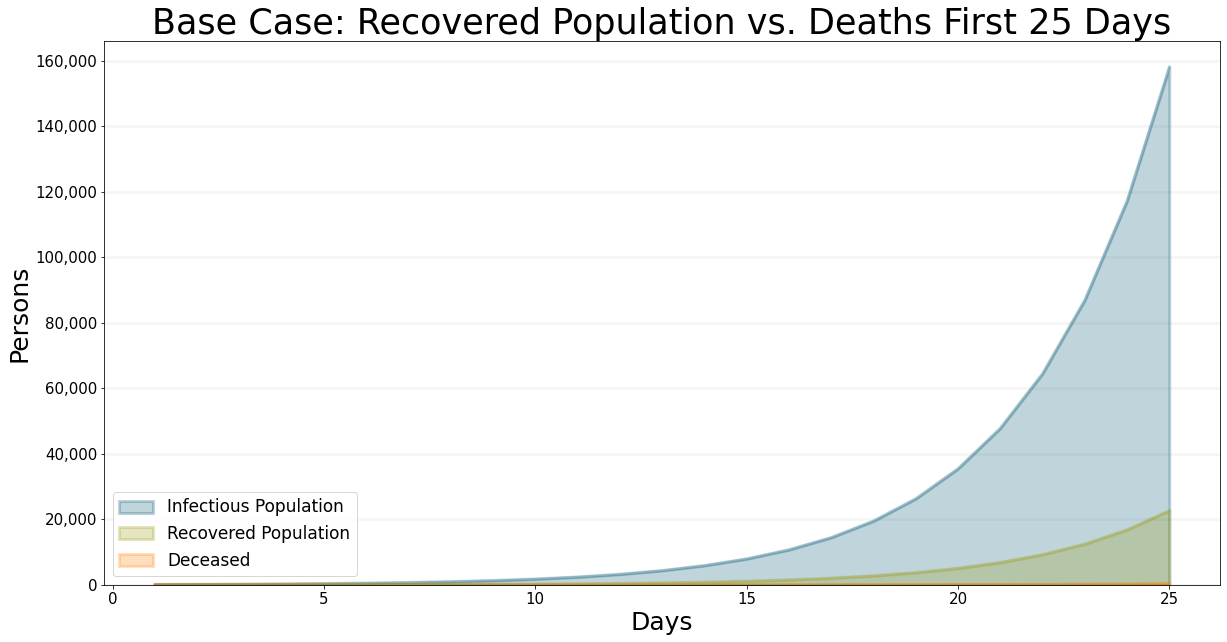

In [33]:
bptk.plot_scenarios(
    scenario_managers=["smSir"],
    scenarios=["base"],
    title="Base Case: Recovered Population vs. Deaths First 25 Days",
    x_label="Days",
    y_label="Persons",
    equations=["infectious","recovered","deceased"],
    series_names={
        "smSir_base_infectious" : "Infectious Population",
        "smSir_base_recovered" : "Recovered Population",
        "smSir_base_deceased": "Deceased"
    },
    visualize_from_period=0,
    visualize_to_period=25
)

Unfortunately, this scenario illustrates well that there are not enough intensive care units available, if the epidemic is left to grow without countermeasures.

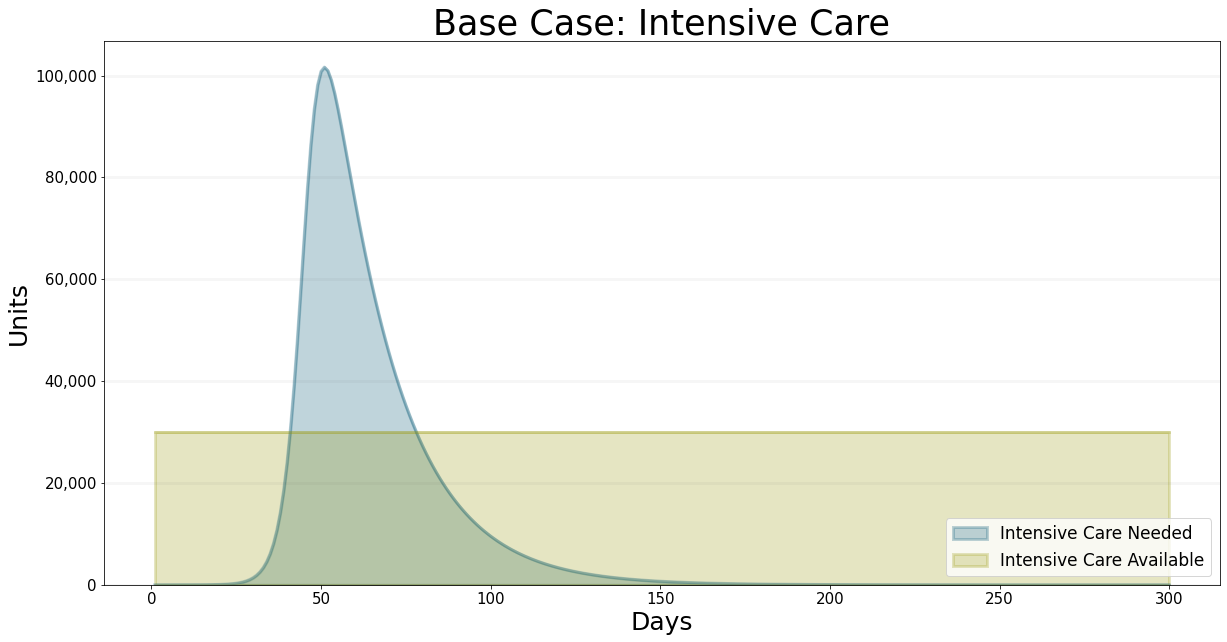

In [34]:
bptk.plot_scenarios(
    scenario_managers=["smSir"],
    scenarios=["base"],
    title="Base Case: Intensive Care",
    x_label="Days",
    y_label="Units",
    equations=["intensive_needed","intensive_available"],
    series_names={
        "smSir_base_intensive_needed" : "Intensive Care Needed",
        "smSir_base_intensive_available" : "Intensive Care Available"  
    },
    visualize_to_period=300
)

### Reducing Spreading of the Virus

How can we reduce the impact of the epidemic? The key parameters that influence the magnitue of the epidemic are the contact rate and the infectivity. 

The only way to reduce the infectivity is to find a vaccine that immunizes the population – this is not a short term option.

The remaining lever is the contact rate - we can reduce this through social distancing.

#### Weak Social Distancing

In this scenario we investiage what happens if we reduce the contact rate, but only by a little at a time in a very slow manner.

In [35]:
points_list_large = []
contact_large = normal_contact_rate(0)
for t in range(int(model.stoptime)):
    if t%40==0 and t!=0 and t < 365:
        contact_large = contact_large - 2
    if t == 600:
        contact_large = 6
    if t == 700:
        contact_large = 10
    if t == 800:
        contact_large = 14
    if t == 900:
        contact_large = 20
    points_list_large.append((t,contact_large))

In [36]:
scenario_weak= bptk.get_scenario("smSir","weakSocialDistancing")
scenario_weak.constants["dashboard_on"]=0.0
scenario_weak.points["variable_contact_rate"]=points_list_large
bptk.reset_simulation_model(scenario_manager="smSir", scenario="weakSocialDistancing") #reset the simulation model to ensure it takes on the new settings

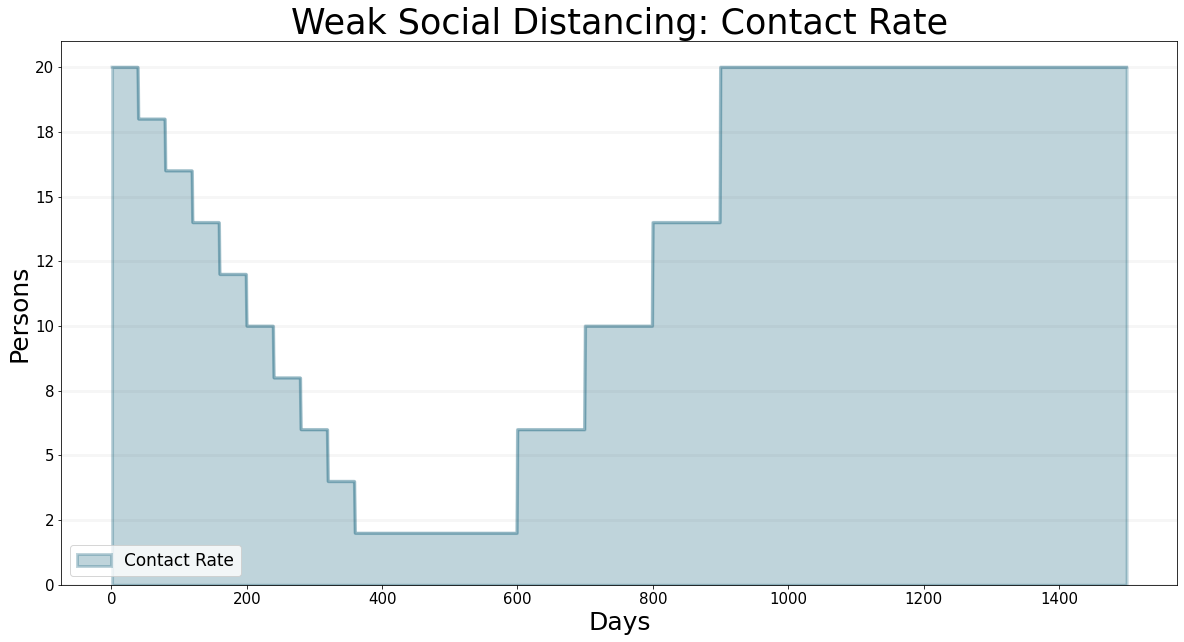

In [37]:
bptk.plot_scenarios(
    scenario_managers=["smSir"],
    scenarios=["weakSocialDistancing"],
    title="Weak Social Distancing: Contact Rate",
    x_label="Days",
    y_label="Persons",
    equations=["contact_rate"],
    series_names={
        "smSir_weakSocialDistancing_contact_rate" : "Contact Rate"
    }
)

It is easy to see this will not help at all:

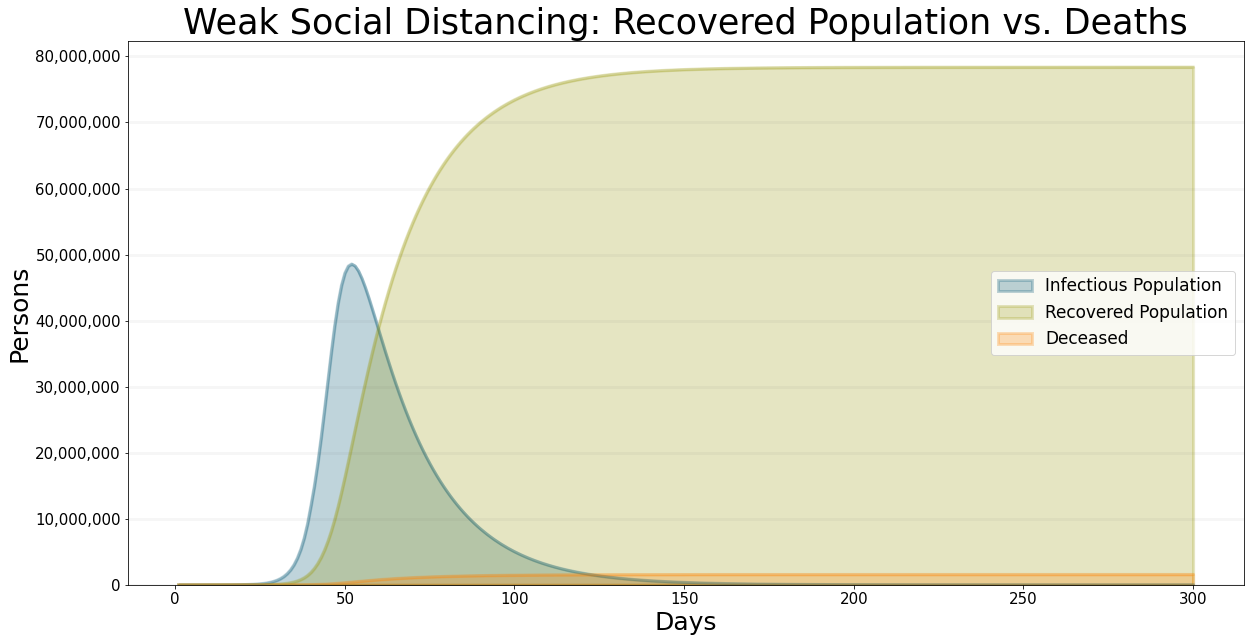

In [38]:
bptk.plot_scenarios(
    scenario_managers=["smSir"],
    scenarios=["weakSocialDistancing"],
    title="Weak Social Distancing: Recovered Population vs. Deaths",
    x_label="Days",
    y_label="Persons",
    equations=["infectious","recovered","deceased"],
    series_names={
        "smSir_weakSocialDistancing_infectious" : "Infectious Population",
        "smSir_weakSocialDistancing_recovered" : "Recovered Population",
        "smSir_weakSocialDistancing_deceased": "Deceased"
    },
    visualize_to_period=300
)

As you can see from the graph above, the number of the infectious population is still growing exponentially. Comparing the base scenario with this slow measures scenario, we can see that there is no siginificant difference. Taking measures too cautiously doesn't stop the spreading of the virus.

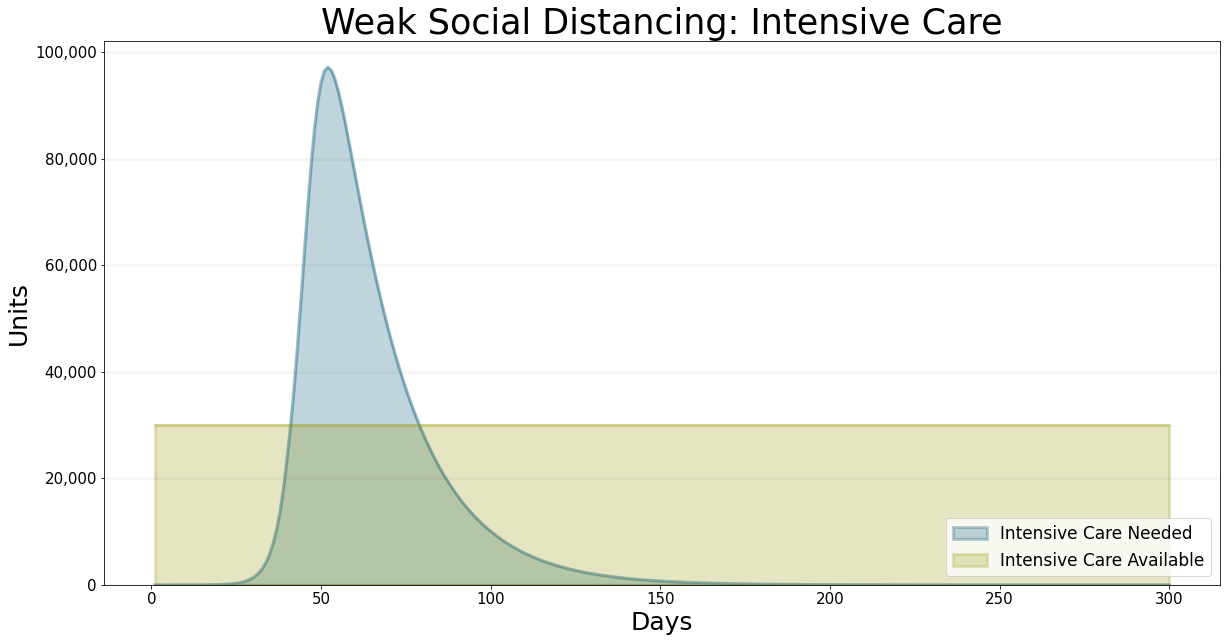

In [39]:
bptk.plot_scenarios(
    scenario_managers=["smSir"],
    scenarios=["weakSocialDistancing"],
    title="Weak Social Distancing: Intensive Care",
    x_label="Days",
    y_label="Units",
    equations=["intensive_needed","intensive_available"],
    series_names={
        "smSir_weakSocialDistancing_intensive_needed" : "Intensive Care Needed",
        "smSir_weakSocialDistancing_intensive_available" : "Intensive Care Available" 
    },
    visualize_to_period=300
)

#### Strong Social Distancing

Cleary we need stronger measures. In this scenario, we investigate what happens if we introduce strong measures rapidly and keep them up for quite some time:

In [40]:
points_list_small = []
contact_small = normal_contact_rate(0)
for t in range(int(model.stoptime)):
    if t==25:
        contact_small= 10
    if t==41:
        contact_small = 5
    if t==500:
        contact_small = 10
    if t==1200:
        contact_small = 20
    points_list_small.append((t,contact_small))

In [41]:
scenario_strong= bptk.get_scenario("smSir","strongSocialDistancing")
scenario_strong.constants["dashboard_on"]=0.0
scenario_strong.points["variable_contact_rate"]=points_list_small
bptk.reset_simulation_model(scenario_manager="smSir", scenario="strongSocialDistancing")

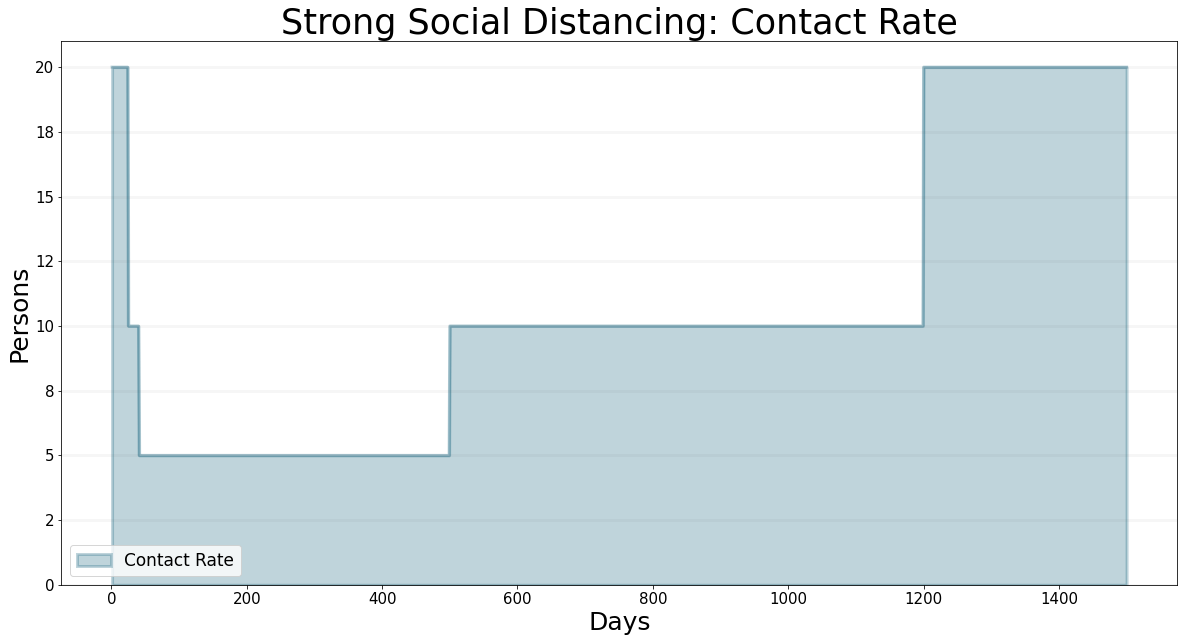

In [42]:
bptk.plot_scenarios(
    scenario_managers=["smSir"],
    scenarios=["strongSocialDistancing"],
    title="Strong Social Distancing: Contact Rate",
    x_label="Days",
    y_label="Persons",
    equations=["contact_rate"],
    series_names={
        "smSir_strongSocialDistancing_contact_rate" : "Contact Rate"
    },
    visualize_to_period=1500
)

The graph below shows that the strict measures help to reduce the spreading of the virus. The infectious population does not grow exponentially. This is good to know - we can achive something by social distancing, the main remaining question is how harsh the measures have to be.

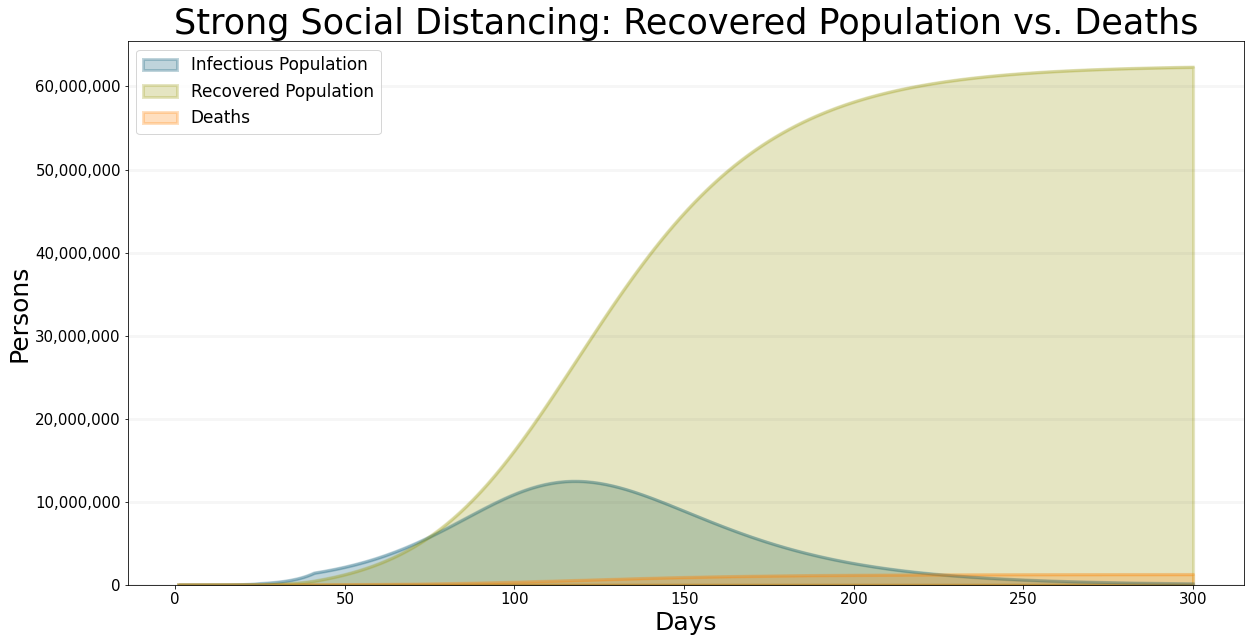

In [43]:
bptk.plot_scenarios(
    scenario_managers=["smSir"],
    scenarios=["strongSocialDistancing"],
    title="Strong Social Distancing: Recovered Population vs. Deaths",
    x_label="Days",
    y_label="Persons",
    equations=["infectious","recovered","deceased"],
    series_names={
        "smSir_strongSocialDistancing_infectious" : "Infectious Population",
        "smSir_strongSocialDistancing_recovered" : "Recovered Population",
        "smSir_strongSocialDistancing_deceased": "Deaths"
    },
    visualize_to_period=300
)

Comparing this scenario with the base scenario we can see how important social distancing is.

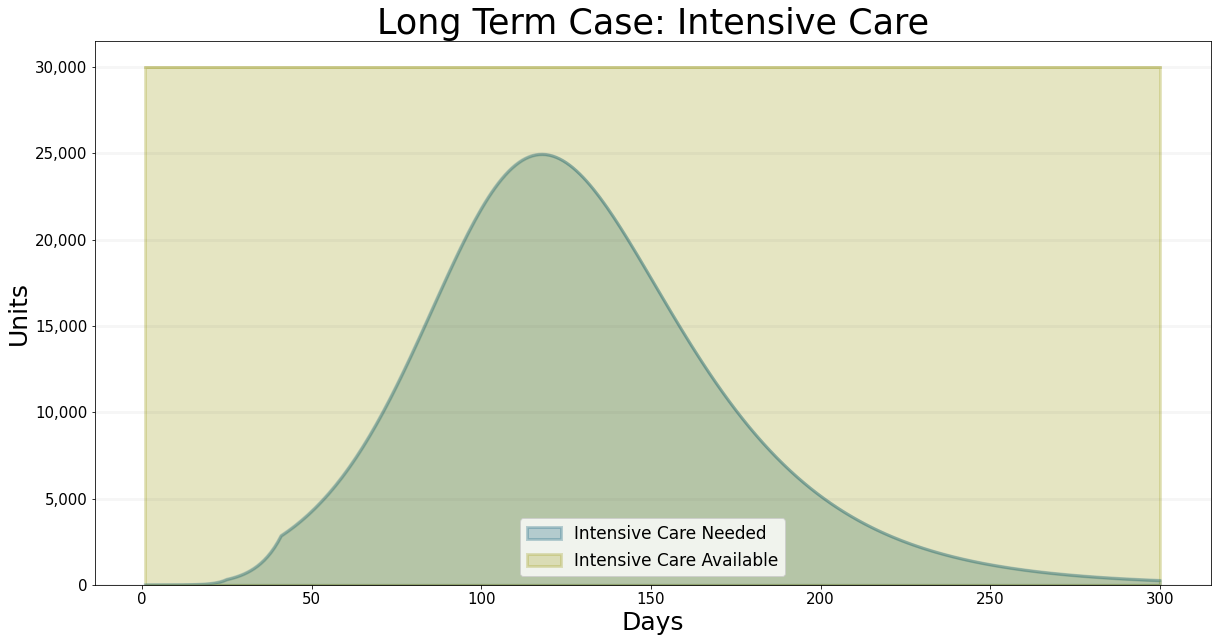

In [44]:
bptk.plot_scenarios(
    scenario_managers=["smSir"],
    scenarios=["strongSocialDistancing"],
    title="Long Term Case: Intensive Care",
    x_label="Days",
    y_label="Units",
    equations=["intensive_needed","intensive_available"],
    series_names={
        "smSir_strongSocialDistancing_intensive_needed" : "Intensive Care Needed",
        "smSir_strongSocialDistancing_intensive_available" : "Intensive Care Available" 
    },
    visualize_to_period=300
)

For this scenario there are enough intensive care units available. A collapse of the heath care system won't happen.

#### Reducing contact rate from large groups to two people for only a short period of time

This scenario shows if taking measures radically but loosening them only after a short period of time to avoid the spreading of the virus. We reduce the contact rate to 2 after ten days and increase the contact rate 90 days later to 20.

In [45]:
points_list_two = []
contact_two = normal_contact_rate(0)
for t in range(int(model.stoptime)):
    if t==10:
        contact_two = 2
    if t==100:
        contact_two = 20
    points_list_two.append((t,contact_two))

In [46]:
scenario_short= bptk.get_scenario("smSir","shortTermMeasures")
scenario_short.constants["dashboard_on"]=0.0
scenario_short.points["variable_contact_rate"]=points_list_two
bptk.reset_simulation_model(scenario_manager="smSir", scenario="shortTermMeasures")

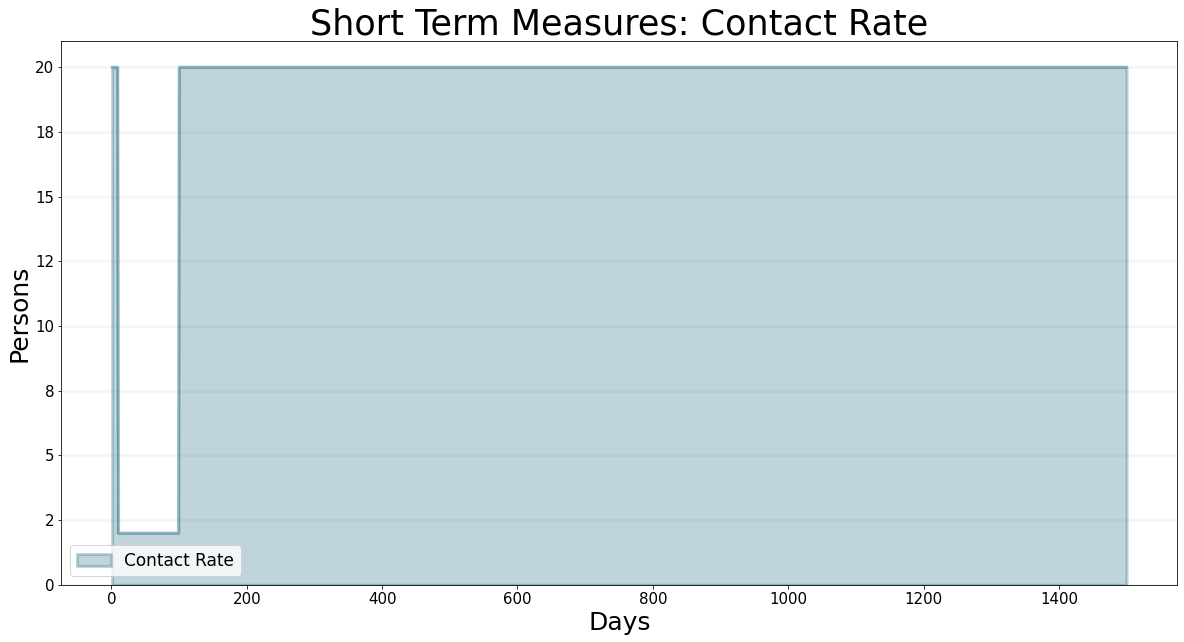

In [47]:
bptk.plot_scenarios(
    scenario_managers=["smSir"],
    scenarios=["shortTermMeasures"],
    title="Short Term Measures: Contact Rate",
    x_label="Days",
    y_label="Persons",
    equations=["contact_rate"],
    series_names={
        "smSir_shortTermMeasures_contact_rate" : "Contact Rate"
    },
    visualize_to_period=1500
)

We immediately see that this doesn't help:

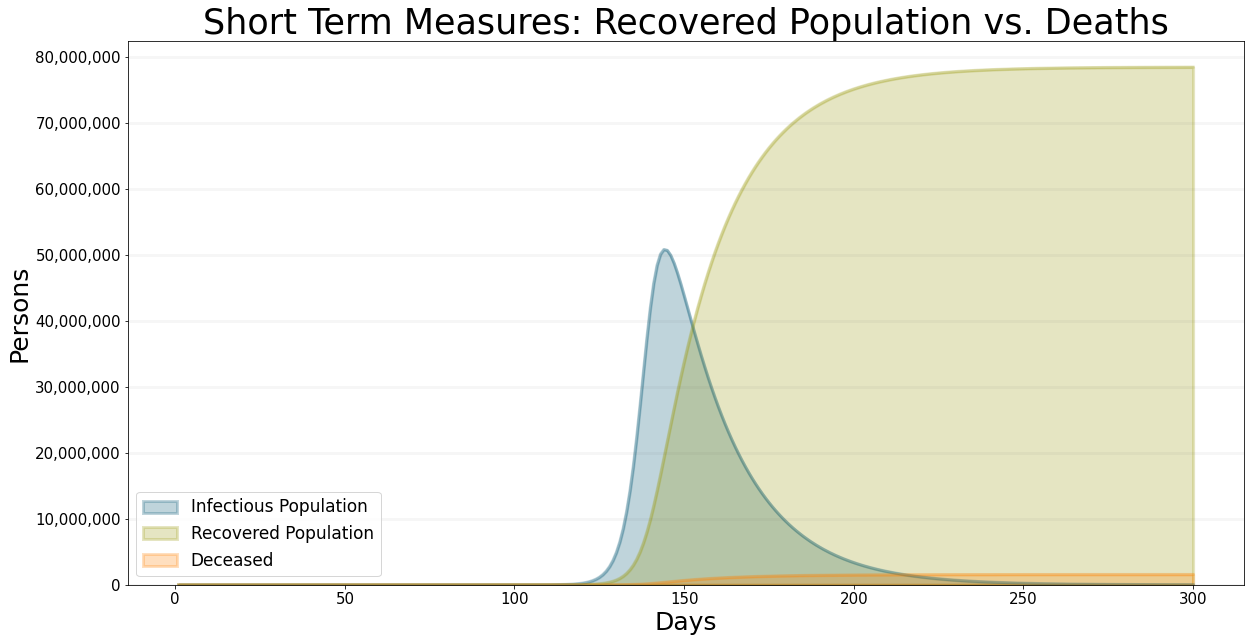

In [48]:
bptk.plot_scenarios(
    scenario_managers=["smSir"],
    scenarios=["shortTermMeasures"],
    title="Short Term Measures: Recovered Population vs. Deaths",
    x_label="Days",
    y_label="Persons",
    equations=["infectious","recovered","deceased"],
    series_names={
        "smSir_shortTermMeasures_infectious" : "Infectious Population",
        "smSir_shortTermMeasures_recovered" : "Recovered Population",
        "smSir_shortTermMeasures_deceased": "Deceased"
    },
    visualize_to_period=300
)

All that we achieve is to move the peak into the future. So this scenario would buy us time, but not more. Of course if we could find a vaccine by then – but clearly there are no guarantees for that.

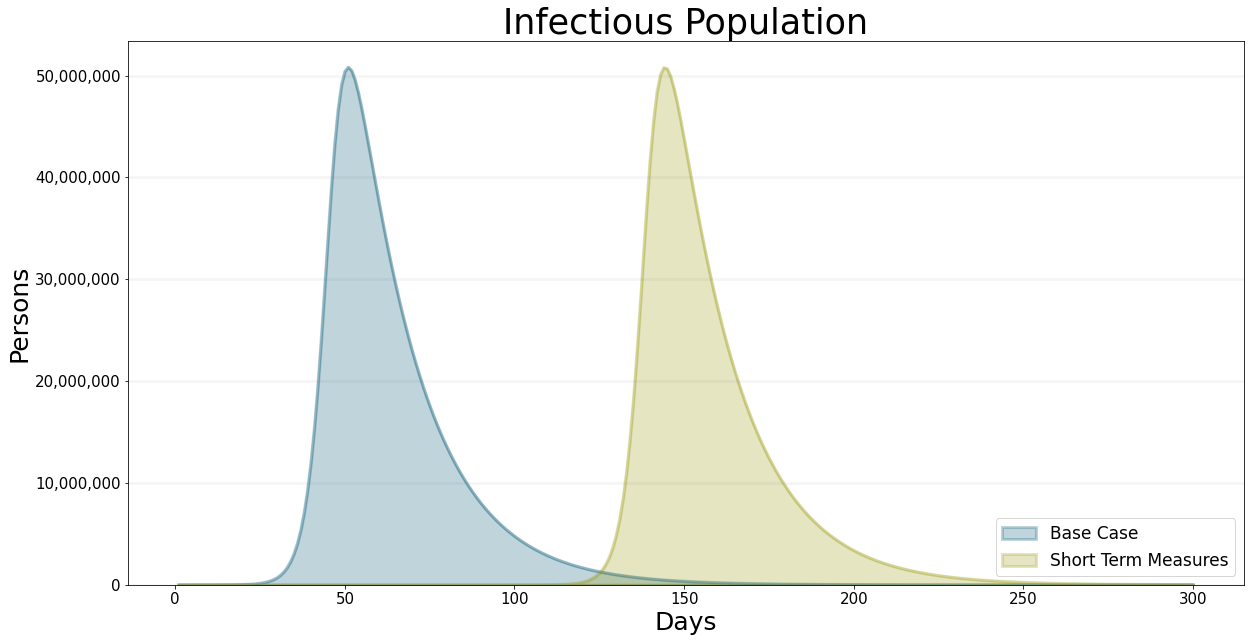

In [49]:
bptk.plot_scenarios(
    scenario_managers=["smSir"],
    scenarios=["shortTermMeasures","base"],
    title="Infectious Population",
    x_label="Days",
    y_label="Persons",
    equations=["infectious"],
    series_names={
        "smSir_base_infectious" : "Base Case",
        "smSir_shortTermMeasures_infectious" : "Short Term Measures"
    },
    visualize_to_period=300
    
)

Comparing this scenario with the base scenario shows that the problem is shifted to a later point in time. This means taking measures for only a short period of time won't stem the virus. 

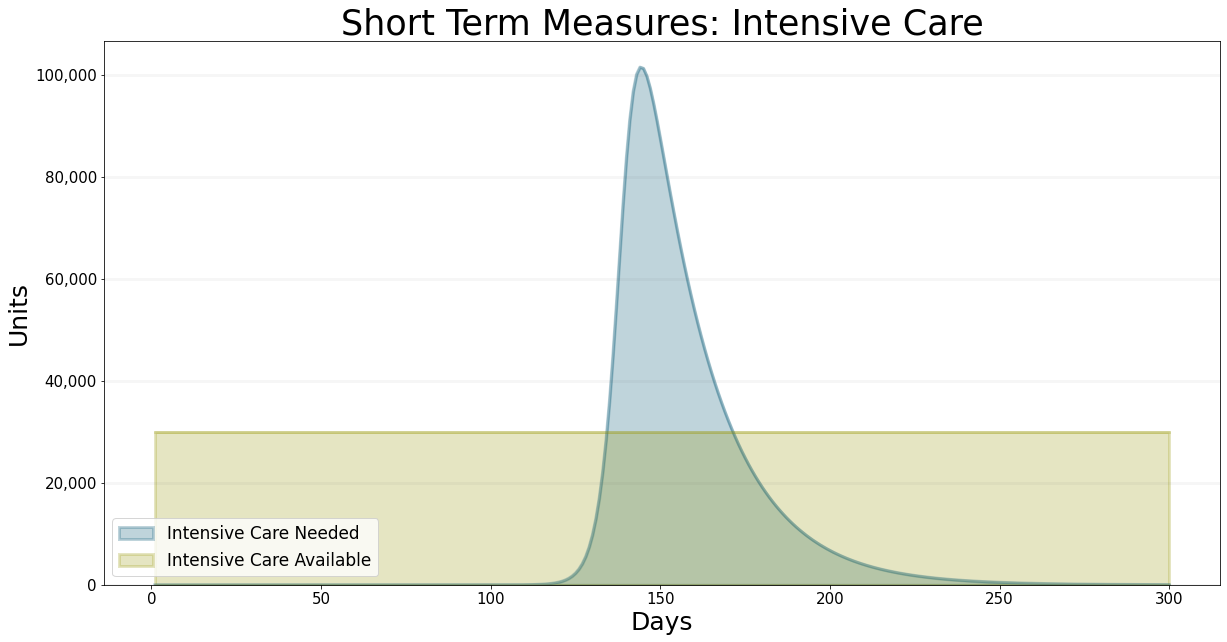

In [50]:
bptk.plot_scenarios(
    scenario_managers=["smSir"],
    scenarios=["shortTermMeasures"],
    title="Short Term Measures: Intensive Care",
    x_label="Days",
    y_label="Units",
    equations=["intensive_needed","intensive_available"],
    series_names={
        "smSir_shortTermMeasures_intensive_needed" : "Intensive Care Needed",
        "smSir_shortTermMeasures_intensive_available" : "Intensive Care Available" 
    },
    visualize_to_period=300
)

As expected, there are not enough intensive care units but only at a later point of time.

## Summary

Though this is actually quite a simple model with only few parameters, we can already simulate some interesting aspects of the COVID-19 pandemic:

* The behaviour over the first 25 days fits nicely with the situation in Germany
* If no measures are taken, we will experience expontential growth of COVID-19 cases in a very short period of time
* Implementing strong social distancing methods leads to the desired result of keeping the number of COVID-19 cases low and not putting to much strain on the health care system.
* Unfortunately the social distancing measures have to be kept up for quite some time in order to have an effect.
* Decreasing the infection rate down to zero doesn't help, because it just moves the problem into the future … we need to build immunity in the population.

The SIR model presented here could be extended in many ways:

* Currently, the model doesn't take into account regional differences.
* The recovery rate as defined in the SIR model doesn't seem to fit reality well … we should seek a more robust implementation.
* The model is only roughly calibrated – meanwhile we have plenty of data on the pandemic from all over the world, so there is an opportunity here for creating a more detailed, calibrated model.

Currently we are working on an agent based version of the model and are also planning to calibrate the model against available data. So make sure to check our Git repo for future updates.